# Neuroglobe Analysis Notebook 🧠 📊

This notebook performs statistical analysis on neuronal projection data extracted by the Neuroglobe Miner.

## Objectives
1.  **Strength Analysis**: Identify the strongest projection targets (Mean across experiments).
2.  **Cortical Index**: Standardized strength (0-1) specifically for cortical areas.
3.  **Tailored Analysis**: Interactive plot for user-defined regions.
4.  **Variability**: Analyze inter-animal consistency using Coefficient of Variation (CV).
5.  **Lateralization**: Compare Ipsilateral vs Contralateral projections.
6.  **Correlations**: Analyze relationships between injection volume and projection strength.

---

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pathlib import Path
import numpy as np

# Configuration
sns.set_theme(style="whitegrid", palette="muted")
DATA_DIR = Path("data")

## 1. Data Loading & Reference Export

**What we are doing:** 
1. Loading the full analysis CSV (`*_full_analysis.csv`).
2. Generating a reference CSV (`region_reference.csv`) containing the full names of all analyzed regions for easy consultation.

**Note:** Unless specified otherwise, the analyses below aggregate data by calculating the **MEAN** across all available experiments.

In [34]:
# Find the analysis file (assuming one seed for now)
csv_files = list(DATA_DIR.glob("*_full_analysis.csv"))
if not csv_files:
    print("No analysis files found! Run src/miner/miner_analysis.py first.")
else:
    csv_path = csv_files[0]
    print(f"Loading: {csv_path}")
    df = pd.read_csv(csv_path)
    
    # Export Reference Table
    ref_table = df[['acronym', 'region_name']].drop_duplicates().sort_values('acronym')
    ref_path = DATA_DIR.parent / "region_reference.csv"
    ref_table.to_csv(ref_path, index=False)
    print(f"[INFO] Region reference saved to: {ref_path}")
    
    display(df.head())

Loading: data\DR_full_analysis.csv
[INFO] Region reference saved to: region_reference.csv


,experiment_id,acronym,region_name,hemisphere_id,target_hemisphere,lateralization,projection_density,projection_energy,projection_volume,volume,is_injection,gender,strain,injection_volume
0,480074702,SOCm,"Superior olivary complex, medial part",1,Left,Contralateral,0.003955,2.426011,0.000426,0.107612,False,F,C57BL/6J,0.137302
1,480074702,IAD,Interanterodorsal nucleus of the thalamus,3,Midline,Midline,0.009503,8.593996,0.001169,0.122993,False,F,C57BL/6J,0.137302
2,480074702,PL2/3,"Prelimbic area, layer 2/3",2,Right,Ipsilateral,0.078810,80.388268,0.018273,0.231868,False,F,C57BL/6J,0.137302
3,480074702,V,Motor nucleus of trigeminal,1,Left,Contralateral,0.002537,1.621735,0.000496,0.195560,False,F,C57BL/6J,0.137302
4,480074702,AId5,"Agranular insular area, dorsal part, layer 5",3,Midline,Midline,0.129204,167.770144,0.215037,1.664319,False,F,C57BL/6J,0.137302


## 2. Global Projection Strength

**Question:** Which regions receive the strongest input from the seed?
**Metric:** Mean `projection_density` across all experiments.
**Visualization:** Bar chart of ALL targets. 
*   **Red**: Cerebral Cortex
*   **Grey**: Other Regions

C:\Users\David\AppData\Local\Temp\ipykernel_6864\301720204.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_stats['projection_density'], y=target_stats.index, palette=colors)


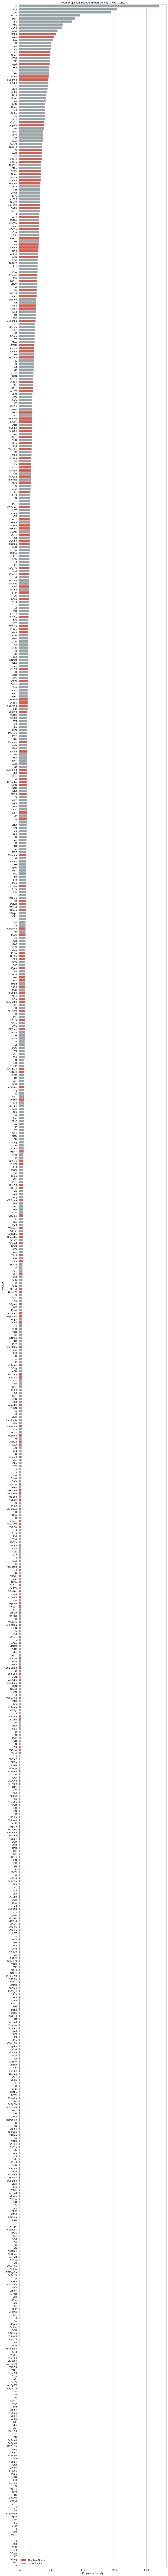

In [35]:
if 'df' in locals():
    # Filter out the seed itself and aggregation structures
    clean_df = df[(df['is_injection'] == False) & (df['acronym'] != 'Isocortex')]
    
    # Group by Region and calculate mean density
    target_stats = clean_df.groupby('acronym').agg({
        'projection_density': 'mean',
        'region_name': 'first'
    }).sort_values(by='projection_density', ascending=False)
    
    # Define Cortical Prefixes (Heuristic based on Allen Ontology)
    cortical_prefixes = ['MO', 'SS', 'VIS', 'AUD', 'RSP', 'ACA', 'PL', 'ILA', 'ORB', 'AI', 'PTLp', 'TEa', 'PERI', 'ECT', 'FRP']
    
    def get_color(acro):
        for prefix in cortical_prefixes:
            if acro.startswith(prefix):
                return "#e74c3c" # Red for Cortex
        return "#95a5a6" # Grey for others
    
    colors = [get_color(acro) for acro in target_stats.index]
    
    # Dynamic height based on number of regions
    plt.figure(figsize=(12, max(6, len(target_stats) * 0.25)))
    sns.barplot(x=target_stats['projection_density'], y=target_stats.index, palette=colors)
    plt.title("Global Projection Strength (Mean Density) - Red: Cortex")
    plt.xlabel("Projection Density")
    plt.ylabel("Region")
    
    # Legend
    legend_elements = [
        Patch(facecolor='#e74c3c', label='Cerebral Cortex'),
        Patch(facecolor='#95a5a6', label='Other Regions')
    ]
    plt.legend(handles=legend_elements)
    plt.show()

## 3. Cortical Connectivity Index (0-1)

**Objective:** Focus exclusively on the Cortex and standardize the strength.
**Method:** 
1. Filter only cortical regions.
2. Calculate `Index = Density / Max_Density`.
3. The region with the highest density (e.g., layer IV of a specific area) will have Index = 1.0.

C:\Users\David\AppData\Local\Temp\ipykernel_6864\1433572205.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ctx_index.values, y=ctx_index.index, palette="Reds_r")


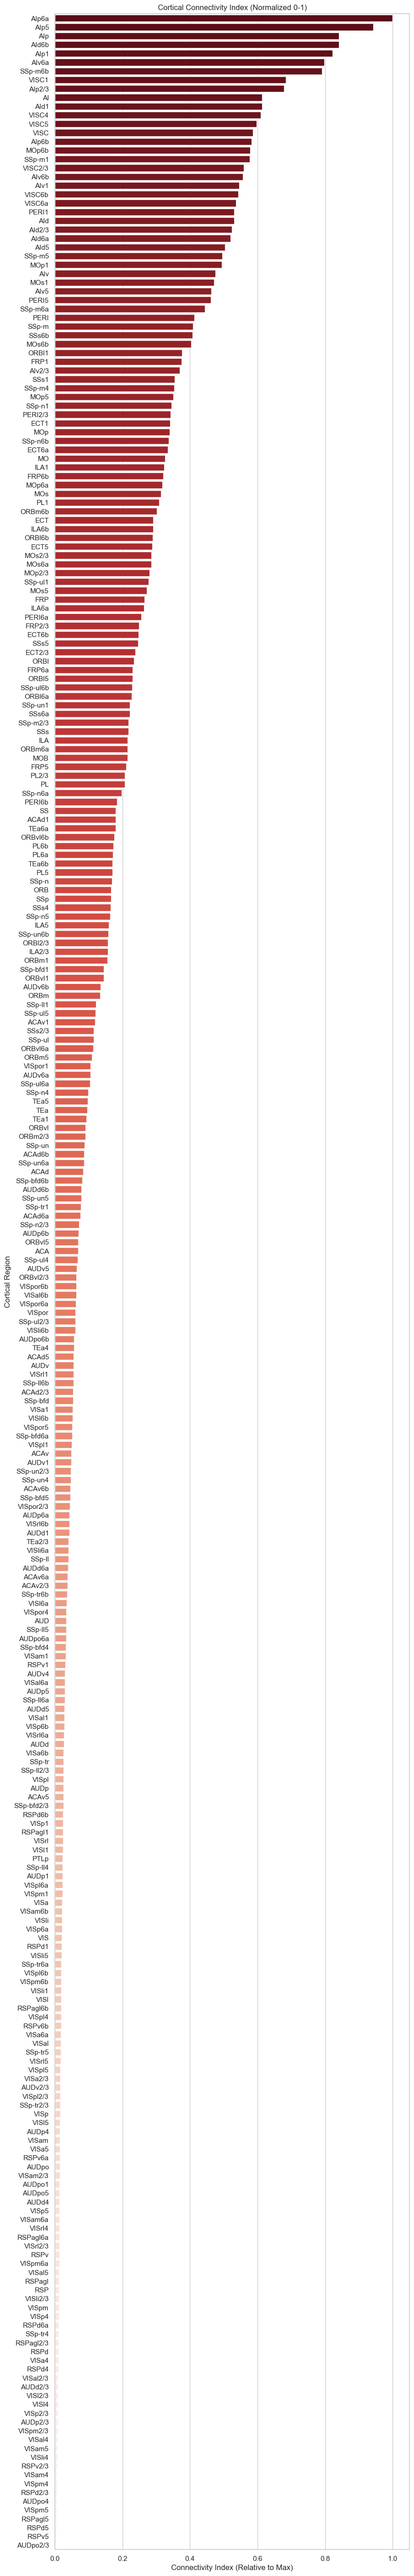

In [36]:
if 'df' in locals():
    # 1. Filter Cortex
    is_cortex = clean_df['acronym'].apply(lambda x: any(x.startswith(p) for p in cortical_prefixes))
    cortex_df = clean_df[is_cortex].copy()
    
    # 2. Calculate Mean Density per Region
    ctx_stats = cortex_df.groupby('acronym')['projection_density'].mean()
    
    # 3. Calculate Index (0-1)
    max_val = ctx_stats.max()
    ctx_index = (ctx_stats / max_val).sort_values(ascending=False)
    
    # Plot
    plt.figure(figsize=(10, max(5, len(ctx_index) * 0.25)))
    sns.barplot(x=ctx_index.values, y=ctx_index.index, palette="Reds_r")
    plt.title("Cortical Connectivity Index (Normalized 0-1)")
    plt.xlabel("Connectivity Index (Relative to Max)")
    plt.ylabel("Cortical Region")
    plt.xlim(0, 1.05)
    plt.show()

## 3.5 Tailored Connectivity Analysis (Color Coded)

**Objective:** Analyze specific regions with color-coding by Macro-Area.
**Macro Areas:** `SSp`, `MOs`, `RSP`, `VIS`, `ACA`, `PL`, `ILA`, `ORB`, `AI`.
**Features:**
1.  **Color Coding**: Each macro-area has a distinct color.
2.  **Legend**: Shows Macro-Area Acronym and Name.
3.  **Colored Labels**: Region names on Y-axis match their group color.

Searching for: ['SSp', 'MOs', 'RSP', 'VIS', 'ACA', 'PL', 'ILA', 'ORB', 'AI']
Found 272 matching regions.


C:\Users\David\AppData\Local\Temp\ipykernel_6864\657999737.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=tailored_index.values, y=tailored_index.index, palette=region_colors)


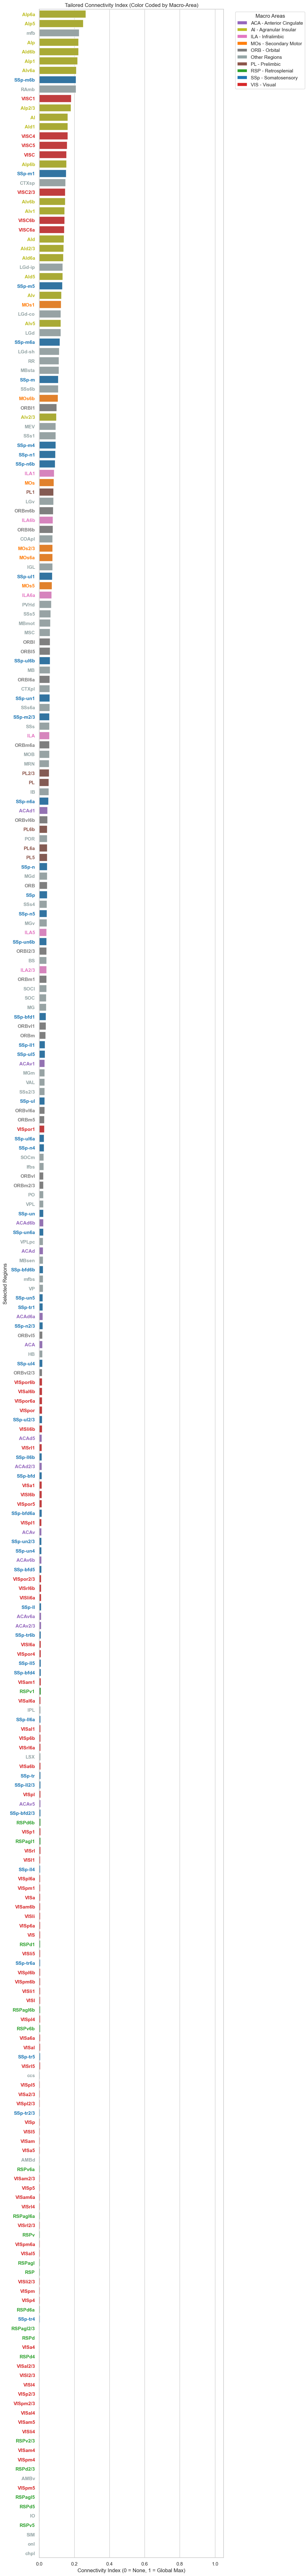

In [37]:
# User Input: List of regions to analyze
SEARCH_TERMS = ["SSp", "MOs", "RSP", "VIS", "ACA", "PL", "ILA", "ORB", "AI"]

# Macro Area Definitions & Colors
MACRO_AREAS = {
    "SSp": "Somatosensory",
    "MOs": "Secondary Motor",
    "RSP": "Retrosplenial",
    "VIS": "Visual",
    "ACA": "Anterior Cingulate",
    "PL":  "Prelimbic",
    "ILA": "Infralimbic",
    "ORB": "Orbital",
    "AI":  "Agranular Insular"
}

# Generate a distinct color palette
palette_colors = sns.color_palette("tab10", n_colors=len(MACRO_AREAS))
MACRO_COLORS = dict(zip(MACRO_AREAS.keys(), palette_colors))
MACRO_COLORS["Other"] = "#95a5a6" # Grey for unmatched

def get_macro_category(acronym):
    for macro in MACRO_AREAS.keys():
        if acronym.startswith(macro):
            return macro
    return "Other"

if 'df' in locals() and 'ref_table' in locals():
    print(f"Searching for: {SEARCH_TERMS}")
    
    # 1. Find matching acronyms
    matched_acronyms = set()
    for term in SEARCH_TERMS:
        matches = ref_table[
            ref_table['acronym'].str.contains(term, case=False, na=False) | 
            ref_table['region_name'].str.contains(term, case=False, na=False)
        ]['acronym'].tolist()
        matched_acronyms.update(matches)
    
    print(f"Found {len(matched_acronyms)} matching regions.")
    
    if matched_acronyms:
        # 2. Filter Data
        tailored_df = clean_df[clean_df['acronym'].isin(matched_acronyms)].copy()
        
        # 3. Calculate Stats
        tailored_stats = tailored_df.groupby('acronym')['projection_density'].mean()
        
        # 4. Calculate Index (Normalized to GLOBAL Max)
        global_max = clean_df.groupby('acronym')['projection_density'].mean().max()
        tailored_index = (tailored_stats / global_max).sort_values(ascending=False)
        
        # 5. Prepare Colors
        region_colors = []
        region_categories = []
        for acro in tailored_index.index:
            cat = get_macro_category(acro)
            region_categories.append(cat)
            region_colors.append(MACRO_COLORS[cat])
            
        # 6. Plot
        plt.figure(figsize=(10, max(4, len(tailored_index) * 0.3)))
        ax = sns.barplot(x=tailored_index.values, y=tailored_index.index, palette=region_colors)
        
        plt.title(f"Tailored Connectivity Index (Color Coded by Macro-Area)")
        plt.xlabel("Connectivity Index (0 = None, 1 = Global Max)")
        plt.ylabel("Selected Regions")
        plt.xlim(0, 1.05)
        
        # 7. Color Code Y-Axis Labels
        for i, tick_label in enumerate(ax.get_yticklabels()):
            tick_label.set_color(region_colors[i])
            tick_label.set_fontweight('bold')
            
        # 8. Custom Legend
        # Identify which categories are actually present in the plot
        present_categories = sorted(list(set(region_categories)))
        legend_handles = []
        for cat in present_categories:
            if cat in MACRO_AREAS:
                label = f"{cat} - {MACRO_AREAS[cat]}"
            else:
                label = "Other Regions"
            legend_handles.append(Patch(facecolor=MACRO_COLORS[cat], label=label))
            
        plt.legend(handles=legend_handles, title="Macro Areas", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("No regions found matching your search terms.")

## 4. Inter-Animal Variability Analysis

**Question:** Which projections are stable across animals and which are variable?
**Metric:** Coefficient of Variation ($CV = \frac{\sigma}{\mu}$).
*   **Low CV**: Consistent projection (Stable).
*   **High CV**: Variable projection (Individual differences or noise).

**Plot:** Scatter Plot of **Mean Density (X)** vs **CV (Y)**.
*   **Bottom-Right**: Strong & Stable (The "Core" targets).
*   **Top-Left**: Weak & Variable (Noise or rare targets).

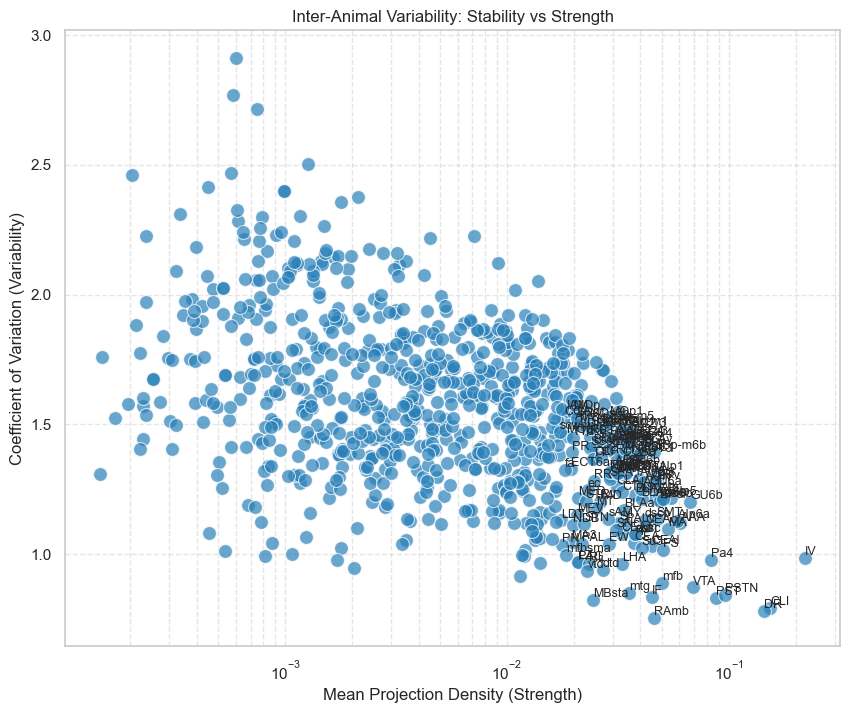

In [38]:
if 'df' in locals():
    # Calculate Mean and Std for each region
    var_stats = clean_df.groupby('acronym')['projection_density'].agg(['mean', 'std'])
    
    # Calculate CV (Coefficient of Variation)
    var_stats['cv'] = var_stats['std'] / var_stats['mean']
    
    # Filter out very low density noise for clearer plot
    plot_data = var_stats[var_stats['mean'] > 0.0001]
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=plot_data, x='mean', y='cv', alpha=0.7, s=100, color='#2980b9')
    
    # Annotate top stable regions (High Mean, Low CV)
    # We select regions with high density and relatively low CV
    stable_core = plot_data[(plot_data['mean'] > plot_data['mean'].quantile(0.8)) & 
                            (plot_data['cv'] < plot_data['cv'].quantile(0.5))]
    
    for acro in stable_core.index:
        plt.text(stable_core.loc[acro, 'mean'], stable_core.loc[acro, 'cv'], 
                 acro, fontsize=9, ha='left', va='bottom')
        
    plt.title("Inter-Animal Variability: Stability vs Strength")
    plt.xlabel("Mean Projection Density (Strength)")
    plt.ylabel("Coefficient of Variation (Variability)")
    plt.xscale('log') # Log scale for density often helps visualization
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()

## 5. Lateralization Analysis

**Question:** Is the projection stronger on the Ipsilateral side (same as injection) vs Contralateral?
**Method:** Boxplot comparing `projection_density` distributions for Ipsi vs Contra.

C:\Users\David\AppData\Local\Temp\ipykernel_6864\3858724800.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clean_df, x='lateralization', y='projection_density', palette="Set2")


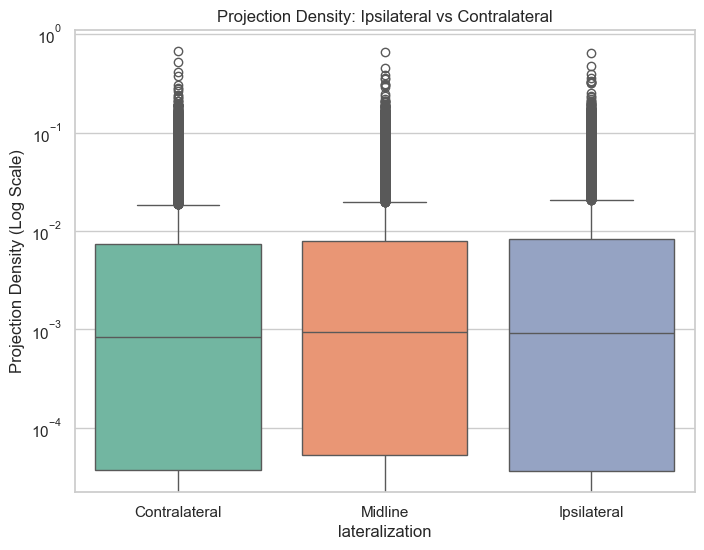

In [39]:
if 'df' in locals():
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=clean_df, x='lateralization', y='projection_density', palette="Set2")
    plt.yscale('log')
    plt.title("Projection Density: Ipsilateral vs Contralateral")
    plt.ylabel("Projection Density (Log Scale)")
    plt.show()

## 6. Correlation: Injection Size vs Output

**Question:** Does a larger injection volume result in a larger total projection volume?
**Method:** Scatter plot of `injection_volume` vs `projection_volume` (summed per experiment).

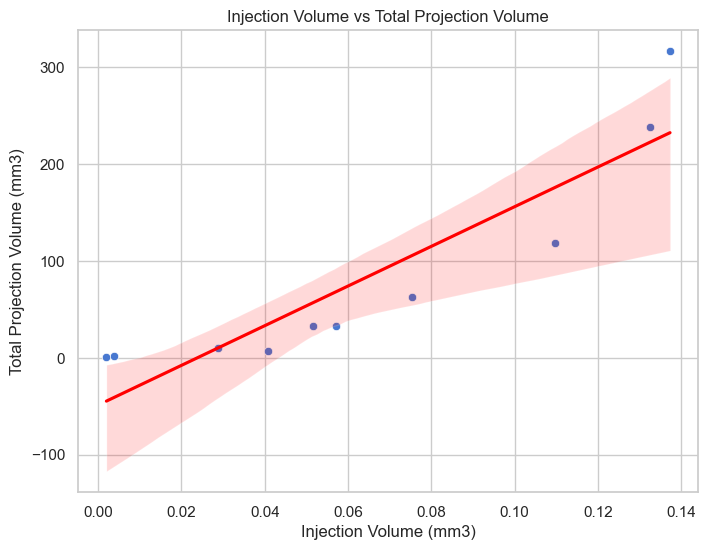

In [40]:
if 'df' in locals():
    # Sum projection volume per experiment
    exp_stats = clean_df.groupby('experiment_id').agg({
        'injection_volume': 'first', 
        'projection_volume': 'sum'
    })
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=exp_stats, x='injection_volume', y='projection_volume')
    sns.regplot(data=exp_stats, x='injection_volume', y='projection_volume', scatter=False, color='red')
    plt.title("Injection Volume vs Total Projection Volume")
    plt.xlabel("Injection Volume (mm3)")
    plt.ylabel("Total Projection Volume (mm3)")
    plt.show()